In [18]:
%pylab notebook

import pandas as pd
import numpy as np
import lightgbm as gbm
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor as RF

Populating the interactive namespace from numpy and matplotlib


In [2]:
def score(Y_pred, Y_true):
    E = np.sqrt(np.sum((Y_pred - Y_true)**2))
    L2pred = np.sqrt(np.sum(Y_pred**2))
    L2true = np.sqrt(np.sum(Y_true**2))
    
    return 2*E/(L2pred + L2true)
    

In [47]:
data = pd.read_csv('../virtual_metering/d2_train.csv')

In [48]:
data = data.drop(['SKAP_18SCSSV3205/BCH/10sSAMP|average', 'SKAP_18HPB320/BCH/10sSAMP|average'], axis=1)

In [49]:
time_cond = (data.timestamp > int(datetime(2014, 3, 1).timestamp()*1000))
data = data[time_cond]

In [86]:
output_columns = ['SKAP_18FI381-VFlLGas/Y/10sSAMP|average',
                  'SKAP_18FI381-VFlLH2O/Y/10sSAMP|average',
                  'SKAP_18FI381-VFlLOil/Y/10sSAMP|average']

output_data = data[output_columns]
input_data  = data.drop(output_columns, axis=1)
input_data  = input_data.drop(['timestamp','Unnamed: 0'], axis=1)
T = data.timestamp

In [87]:
rcond = (data.index < len(data)*0.7)
Y_train = output_data[rcond]
Y_test  = output_data[~rcond]
X_train = input_data[rcond]
X_test = input_data[~rcond]
T_train = T[rcond]
T_test  = T[~rcond]

In [102]:
Y_train = Y_train.rolling(2).median()
Y_train = Y_train.fillna(method='bfill')

In [103]:
Y_train_gas = Y_train['SKAP_18FI381-VFlLGas/Y/10sSAMP|average']
Y_train_oil = Y_train['SKAP_18FI381-VFlLOil/Y/10sSAMP|average']
Y_train_wat = Y_train['SKAP_18FI381-VFlLH2O/Y/10sSAMP|average']
Y_test_gas = Y_test['SKAP_18FI381-VFlLGas/Y/10sSAMP|average']
Y_test_oil = Y_test['SKAP_18FI381-VFlLOil/Y/10sSAMP|average']
Y_test_wat = Y_test['SKAP_18FI381-VFlLH2O/Y/10sSAMP|average']

In [104]:
lgbm = gbm.LGBMRegressor(n_estimators=20)
lgbm.fit(X_train, Y_train_gas)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=20,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [105]:
Y_pred_gas = lgbm.predict(X_test)

In [106]:
Y_self_gas = lgbm.predict(X_train)

In [107]:
score(Y_pred_gas, Y_test_gas)

0.13841619233796737

<IPython.core.display.Javascript object>


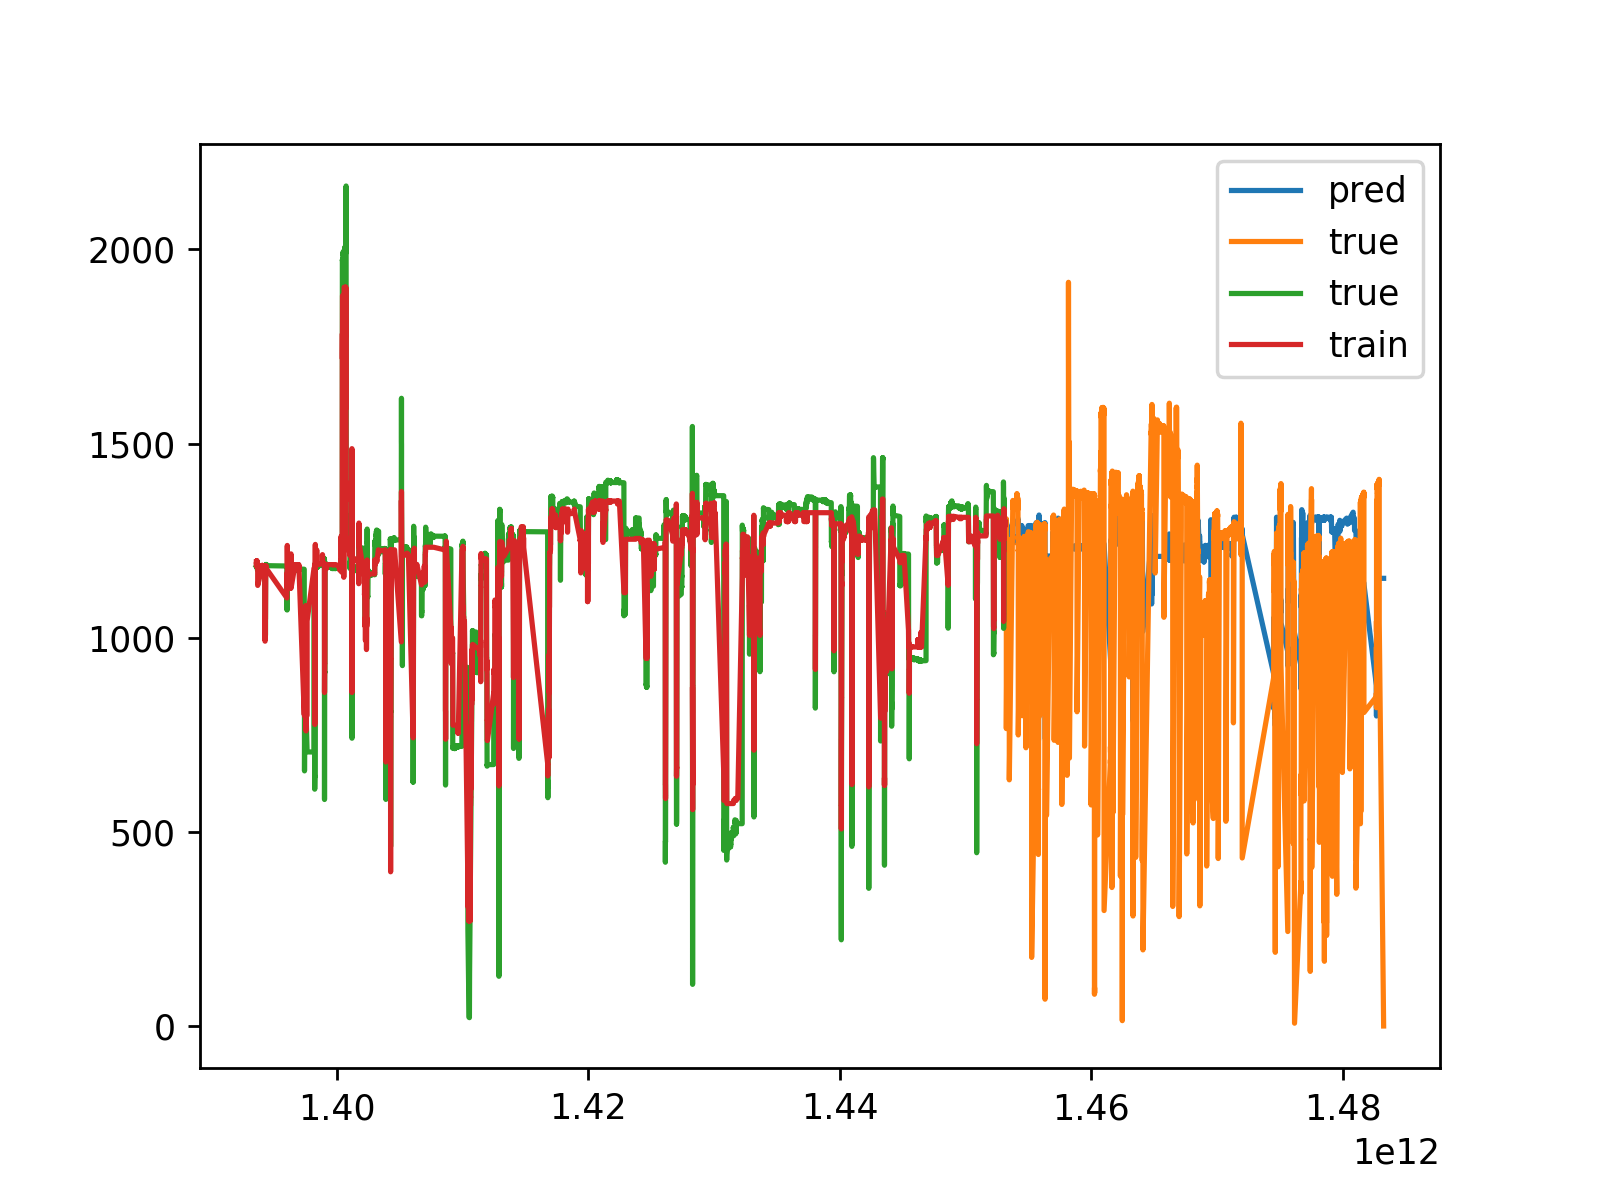

In [108]:
plt.figure()
plt.plot(T_test, Y_pred_gas, label='pred')
plt.plot(T_test, Y_test_gas.values, label='true')
plt.plot(T_train, Y_train_gas, label='true')
plt.plot(T_train, Y_self_gas, label='train')


plt.legend()

In [39]:
var_list = X_test.columns
importance = lgbm.feature_importances_

In [41]:
imp = pd.DataFrame()
imp['Name'] = var_list
imp['Ranking'] = importance

In [45]:
imp.sort_values(by='Ranking')

,Name,Ranking
3,SKAP_18HV3806/BCH/10sSAMP|stepinterpolation,0
14,SKAP_18ESV3213/BCH/10sSamp|stepinterpolation,0
19,SKAP_18ESV3220/BCH/10sSamp|stepinterpolation,0
12,SKAP_18ESV3207/BCH/10sSamp|stepinterpolation,0
11,SKAP_18ESV3206/BCH/10sSamp|stepinterpolation,0
15,SKAP_18ESV3214/BCH/10sSAMP|stepinterpolation,6
16,SKAP_18ESV3215/BCH/10sSamp|stepinterpolation,9
13,SKAP_18ESV3211/BCH/10sSAMP|stepinterpolation,12
18,SKAP_18ESV3219/BCH/10sSamp|stepinterpolation,14
17,SKAP_18ESV3218/BCH/10sSamp|stepinterpolation,34
